In [1]:
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
import torch

# 创建数据库引擎
table_hk_daily = "hk_customs_daily"
database_url = "sqlite:///../data/data.sqlite"
engine = create_engine(database_url)

# define hyper paras
use_standard_scaler = True
mode = 'predict'
model_name = 'transformer'  # transformer,saits
save_imputed_data = False
device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
saved_model = {
    "saits": 'saits_hk_imputation_20240222235322.pypots',
    "transformer": "transformer_hk_imputation_20240305144139.pypots"
}
num_features = 1

In [2]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

query = f"SELECT date,global_airport_entry FROM hk_customs_daily"
df = pd.read_sql_query(query, engine)

# save original df
df_reindex = df.copy()
df_reindex_scaled = df.copy()

# use scalar
scalers = {}
if use_standard_scaler:
    for column in df_reindex_scaled.columns:
        if column not in ['date']:
            scaler = MinMaxScaler()
            df_reindex_scaled[column] = scaler.fit_transform(df_reindex_scaled[column].values.reshape(-1, 1)).reshape(
                -1)
            scalers[column] = scaler

# make a date range
date_range = pd.date_range(start=pd.to_datetime('2019-01-01'), end=df_reindex_scaled['date'].max())

# 重建索引，填充缺失的日期
df_reindex_scaled['date'] = pd.to_datetime(df_reindex_scaled['date'])
df_reindex_scaled.set_index('date', inplace=True)  # 设置日期列为索引
df_reindex_scaled = df_reindex_scaled.reindex(date_range).rename_axis('date')

# do same thing to df
df_reindex['date'] = pd.to_datetime(df_reindex['date'])
df_reindex.set_index('date', inplace=True)  # 设置日期列为索引
df_reindex = df_reindex.reindex(date_range).rename_axis('date')

# # 筛选出不在该日期区间的列
# start_date = '2020-1-24'
# end_date = '2023-04-01'
# df = df[(df['date'] < start_date) | (df['date'] > end_date)]

num_samples = df_reindex_scaled.values.shape[0]
num_features = df_reindex_scaled.values.shape[1]  # 减去date

In [3]:
df_reindex_scaled

,global_airport_entry
date,
2019-01-01,NaN
2019-01-02,NaN
2019-01-03,NaN
2019-01-04,NaN
2019-01-05,NaN
...,...
2024-02-15,0.379137
2024-02-16,0.388598
2024-02-17,0.334998


In [4]:
from pygrinder import mcar

X = df_reindex_scaled.values  # drop date column
X = X.reshape(1, num_samples, -1)
X_ori = X  # keep X_ori for validation

X = mcar(X, 0.1)  # randomly hold out 10% observed values as ground truth
dataset = {"X": X}  # X for model input

In [5]:
from pypots.optim import Adam
import torch
import datetime
from pypots.imputation import SAITS, Transformer
from pypots.utils.metrics import calc_mae
from pygrinder.utils import fill_and_get_mask_torch

# Model training. This is PyPOTS showtime.

if mode == 'train':
    if model_name == 'saits':
        saits = SAITS(n_steps=num_samples,
                      n_features=num_features,
                      n_layers=4,
                      d_model=128,
                      d_inner=128,
                      n_heads=4,
                      d_k=32,
                      d_v=64,
                      dropout=0.1,
                      epochs=100,
                      device=device)
        saits.fit(dataset)
        imputation = saits.impute(dataset)  # impute the originally-missing values and artificially-missing values
        saits.save(saving_path=f"../models/saits_hk_imputation_{datetime.datetime.now().strftime('%Y%m%d%H%M%S')}",
                   overwrite=False)
    elif model_name == 'transformer':
        transformer = Transformer(
            n_steps=num_samples,
            n_features=num_features,
            n_layers=4,
            d_model=196,
            d_inner=128,
            n_heads=6,
            d_k=32,
            d_v=64,
            dropout=0.1,
            attn_dropout=0,
            epochs=200,
            # give the optimizer. Different from torch.optim.Optimizer, you don't have to specify model's parameters when
            # initializing pypots.optim.Optimizer. You can also leave it to default. It will initilize an Adam optimizer with lr=0.001.
            optimizer=Adam(lr=1e-3),
            # Set it to None to use the default device (will use CPU if you don't have CUDA devices).
            # You can also set it to 'cpu' or 'cuda' explicitly, or ['cuda:0', 'cuda:1'] if you have multiple CUDA devices.
            device=device,
        )

        # train the model on the training set, and validate it on the validating set to select the best model for testing in the next step
        transformer.fit(dataset)
        # the testing stage, impute the originally-missing values and artificially-missing values in the test set
        imputation = transformer.impute(dataset)
        transformer.save(
            saving_path=f"../models/transformer_hk_imputation_{datetime.datetime.now().strftime('%Y%m%d%H%M%S')}",
            overwrite=False)
elif mode == 'predict':
    model = torch.load(f'../models/{saved_model["transformer"]}',map_location=device)
    model.eval()
    _X, missing_mask = fill_and_get_mask_torch(torch.Tensor(X))
    inputs = {
        "X": _X,
        "X_ori": _X,
        "indicating_mask": np.isnan(X) & np.isnan(X_ori),
        "missing_mask": missing_mask,
    }
    for k in inputs:
        inputs[k] = torch.Tensor(inputs[k]).to(device)
    with torch.no_grad():
        imputation = model(inputs)
        imputation = imputation['imputed_data'].cpu().detach().numpy()

2024-03-05 14:56:21 [ERROR]: ❌ No module named 'torch_geometric'
Note torch_geometric is missing, please install it with 'pip install torch_geometric torch_scatter torch_sparse' or 'conda install -c pyg pyg pytorch-scatter pytorch-sparse'
2024-03-05 14:56:21 [ERROR]: ❌ name 'MessagePassing' is not defined
Note torch_geometric is missing, please install it with 'pip install torch_geometric torch_scatter torch_sparse' or 'conda install -c pyg pyg pytorch-scatter pytorch-sparse'


In [6]:
indicating_mask = np.isnan(X) ^ np.isnan(X_ori)  # only calculate takeaway mae, do not care NaN values
indicating_mask_and = (np.isnan(X) & np.isnan(X_ori)).reshape(num_samples, num_features)[:, 0]

mae = calc_mae(imputation, np.nan_to_num(X_ori),
               indicating_mask)  # calculate mean absolute error on the ground truth (artificially-missing values)

imputation, mae

(array([[[0.37425044],
         [0.37523606],
         [0.40164074],
         ...,
         [0.33499798],
         [0.32649896],
         [0.42966592]]], dtype=float32),
 0.023563234948427537)

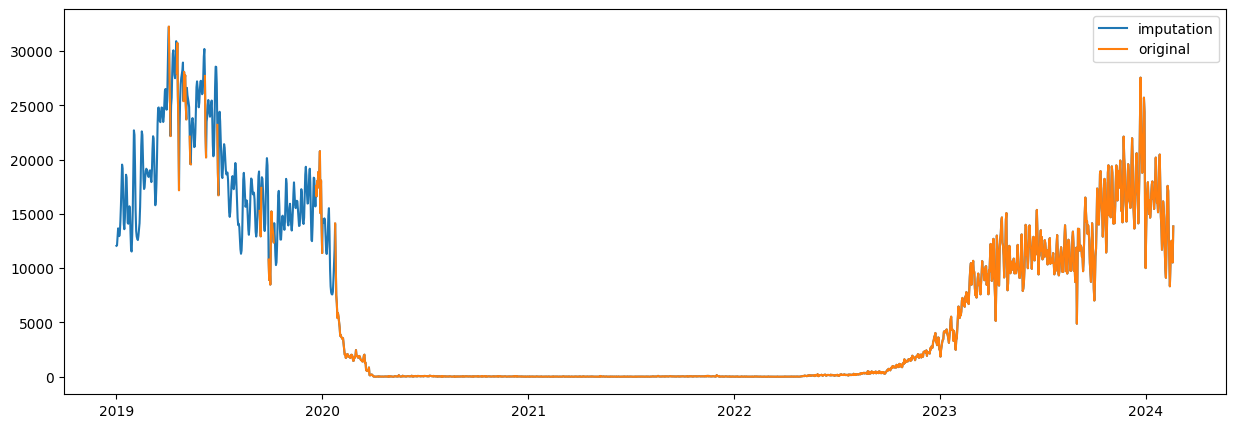

In [7]:
from matplotlib import pyplot as plt

# float to int
imputation_val = pd.DataFrame()
if use_standard_scaler:
    for i, column in enumerate(df_reindex_scaled.columns):
        if column not in ['date']:
            imputation_val[column] = scalers[column].inverse_transform(
                imputation.reshape(num_samples, num_features).reshape(-1, 1)).reshape(-1)
    imputation_val = imputation_val.astype('int')
else:
    imputation_val = pd.DataFrame(imputation.reshape(num_samples, num_features).astype('int'), columns=df.columns[1:])

imputation_val = pd.DataFrame({
    col: np.where(indicating_mask_and, imputation_val[col], df_reindex[col]) for col
    in
    df_reindex.columns
})
imputation_val.index = df_reindex.index

# revert data and draw
plt.figure(figsize=(15, 5))
plt.plot(imputation_val.index, imputation_val['global_airport_entry'], label='imputation')
plt.plot(df_reindex.index, df_reindex['global_airport_entry'], label='original')
plt.legend()
plt.show()

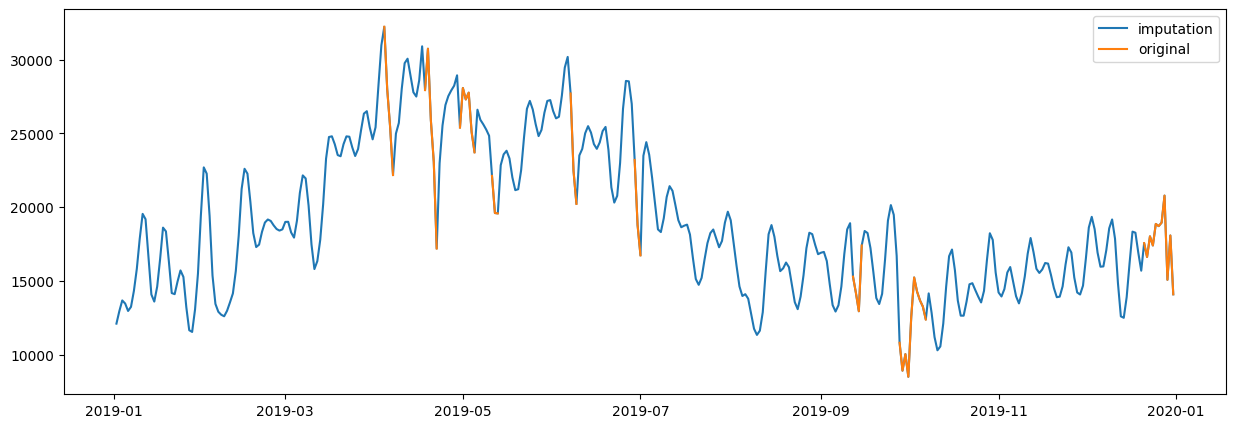

In [8]:
start_date = '2019-01-01'
end_date = '2020-01-01'
imputation_val_1 = imputation_val[(imputation_val.index > start_date) & (imputation_val.index < end_date)]
original_val_1 = df_reindex[(df_reindex.index > start_date) & (df_reindex.index < end_date)]

plt.figure(figsize=(15, 5))
plt.plot(imputation_val_1.index, imputation_val_1['global_airport_entry'], label='imputation')
plt.plot(original_val_1.index, original_val_1['global_airport_entry'], label='original')
plt.legend()
plt.show()

# perfect result

# PCA + t-SNE 评价数据分布

可以看出，不仅mae非常可观，可视化的图也表示填充的数据和原分布基本相似

# Move data into Database

In [10]:
# if save_imputed_data is True:
imputation_val.to_sql('hk_customs_daily_imputed', con=engine, if_exists='replace', index=True)

1876